In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
from rapidfuzz import fuzz, process

In [14]:
ihds1_1_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0001/22626-0001-Data.tsv', sep='\t', low_memory=False) # Individual
ihds1_2_hhl = pd.read_csv('../../ICPSR_IHDS-1/DS0002/22626-0002-Data.tsv', sep='\t', low_memory=False) # Household

''' Not used
ihds3_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0003/22626-0003-Data.tsv', sep='\t', low_memory=False) # Medical
ihds4_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0004/22626-0004-Data.tsv', sep='\t', low_memory=False) # Nonresident
ihds5_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0005/22626-0005-Data.tsv', sep='\t', low_memory=False) # School
ihds6_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0006/22626-0006-Data.tsv', sep='\t', low_memory=False) # Birth history
ihds7_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0007/22626-0007-Data.tsv', sep='\t', low_memory=False) # Village
ihds8_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0008/22626-0008-Data.tsv', sep='\t', low_memory=False) # Crop
'''

" Not used\nihds3_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0003/22626-0003-Data.tsv', sep='\t', low_memory=False) # Medical\nihds4_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0004/22626-0004-Data.tsv', sep='\t', low_memory=False) # Nonresident\nihds5_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0005/22626-0005-Data.tsv', sep='\t', low_memory=False) # School\nihds6_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0006/22626-0006-Data.tsv', sep='\t', low_memory=False) # Birth history\nihds7_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0007/22626-0007-Data.tsv', sep='\t', low_memory=False) # Village\nihds8_ind = pd.read_csv('../../ICPSR_IHDS-1/DS0008/22626-0008-Data.tsv', sep='\t', low_memory=False) # Crop\n"

In [15]:
print("IHDS-1.1 columns:\n", ihds1_1_ind.columns.tolist())
print("IHDS-1.2 columns:\n", ihds1_2_hhl.columns.tolist())

''' Not used
print("IHDS-1.3 columns:\n", ihds3_ind.columns.tolist())
print("IHDS-1.4 columns:\n", ihds4_ind.columns.tolist())
print("IHDS-1.5 columns:\n", ihds5_ind.columns.tolist())
print("IHDS-1.6 columns:\n", ihds6_ind.columns.tolist())
print("IHDS-1.7 columns:\n", ihds7_ind.columns.tolist())
print("IHDS-1.8 columns:\n", ihds8_ind.columns.tolist())
'''

print(ihds1_1_ind.shape)
print(ihds1_2_hhl.shape)

''' Not used
print(ihds3_ind.shape)
print(ihds4_ind.shape)
print(ihds5_ind.shape)
print(ihds6_ind.shape)
print(ihds7_ind.shape)
print(ihds8_ind.shape)
'''

IHDS-1.1 columns:
 ['stateid', 'distid', 'psuid', 'hhid', 'hhsplitid', 'personid', 'caseid', 'idhh', 'idpsu', 'stateid2', 'distname', 'dist01', 'urban', 'metro6', 'sweight', 'Npersons', 'Nchildren', 'Nteens', 'Nadults', 'Nmarriedf', 'Nmarriedm', 'copc', 'groups8', 'hc9', 'hhassets', 'hhed5adult', 'hhed5f', 'hhed5m', 'wkany', 'wkfarm', 'wkanimal', 'wkagwage', 'wknonag', 'wksalary', 'wkbusiness', 'income', 'incfarm', 'incagwage', 'incnonag', 'incsalary', 'incbus', 'incremit', 'incgovt', 'incother', 'pcpl', 'poor', 'ro0', 'ro1', 'ro3', 'ro4', 'ro5', 'ro6', 'ro7', 'ro8', 'ro9', 'fm28', 'fm29', 'fm30', 'fm31', 'an5', 'an6', 'an7', 'ws0N', 'ws6year', 'ws8annual', 'ws8hourly', 'ws10', 'ws1', 'ws2a', 'ws3a', 'ws4a', 'ws5a', 'ws6a', 'ws6yeara', 'ws7a', 'ws8a', 'ws8annuala', 'ws8hourlya', 'ws9a', 'ws10a', 'ws11a', 'ws12a', 'nf7', 'nf8', 'nf9', 'nf16', 'nf17', 'nf18', 'nf25', 'nf26', 'nf27', 'in7', 'in7r', 'in8', 'in8r', 'in9', 'in9r', 'in10', 'in10r', 'in11', 'in11r', 'in12', 'in12r', 'in13', 'i

' Not used\nprint(ihds3_ind.shape)\nprint(ihds4_ind.shape)\nprint(ihds5_ind.shape)\nprint(ihds6_ind.shape)\nprint(ihds7_ind.shape)\nprint(ihds8_ind.shape)\n'

In [24]:
print(ihds1_1_ind['ro5'].head(3))

# Basic Features -----------------------------
basic_column_map = { 
    'stateid': 'stateid',           # unique 33
    'distid': 'distid',             # unique 61
    'distname': 'distname',         # unique 375
    'personid': 'person_id',        # unique 38
    'hhid': 'household_id',         # unique 52
    'ro3': 'sex',                   # unique 2
    'ro5': 'age',                   # unique 108
    'ed3': 'attended_school',       # unique 2
    'ed4': 'enrolled_or_completed', # unique 2
    'ed5': 'years_of_education',    # unique 16
    'ed6': 'ever_repeated',         # unique 2
    'ed7': 'englisch_ability',      # unique 3
    'ed12': 'highest_degree',       # unique 6
    'income': 'household_income',   # unique 21111
    'groups8': 'caste',             # unique 8
    'ws8annual': 'Ann_earnings_tot',# unique 3052
    'hhassets': 'hhassets',          # unique 31
}

# More Features -----------------------------
more_column_map = {
    'INCOME': 'household_income',     # unique 21111
    'STATEID': 'stateid',             # unique 33
    'DISTID': 'distid',               # unique 61
    'DISTNAME': 'distname',           # unique 375
    'HHID': 'household_id',           # unique 52
    'HHED5ADULT': 'highest_adult_ed', # unique 16
    'HHED5M': 'highest_male_ed',      # unique 16
    'HHED5F': 'highest_female_ed',    # unique 16
    'HHED2': 'literate_ad',           # unique 2 (at least one literate adult in hh) 
    'Nsalary': 'Nhh_salaried',        # unique 7 (paid monthly or annually)  
    'Nagwage': 'Nhh_ag_wage',         # unique 10 (paid daily and have agricultural occupation)  
    'Nnonag': 'Nhh_nonag_wage',       # unique 9 (paid daily and no ag occupation)  
    'Nbusiness': 'Nhh_fam_bus',       # unique 8
    'HHASSETS': 'hhassets',           # unique 31
    'CG18': 'owns_car',               # unique 2
    'CG21': 'owns_computer',          # unique 2
    'NPERSONS': 'npersons',           # unique 38 (# persons in hh)
    'NCHILD': 'nchild',               # unique 18
    'NADULTS': 'nadults',             # unique 19
    'URBAN': 'urban',                 # unique 2 (0-rural, 1-urban)
    'METRO6': 'metro',                # unique 7
    'GROUPS8': 'caste_rel',           # unique 8
}
# 'mh3': 'marriage_status',
# 'id20': 'father_education'

used_cols = list(more_column_map.keys())
features = ihds1_2_hhl[used_cols].rename(columns=more_column_map)


print(features.head(20))


0    50
1    45
2    22
Name: ro5, dtype: int64
   household_income  stateid  distid  distname  household_id  \
0          52871.68        1       2       102             1   
1          262118.9        1       2       102             2   
2             80050        1       2       102             3   
3           39193.2        1       2       102             4   
4          434355.4        1       2       102             5   
5            102291        1       2       102             6   
6          14513.49        1       2       102             7   
7          41767.36        1       2       102             8   
8          44133.45        1       2       102             9   
9          652577.1        1       2       102            10   
10            15550        1       2       102            11   
11          35340.7        1       2       102            12   
12         16855.76        1       2       102            13   
13         71214.97        1       2       102          

In [25]:
path_basic_features = '../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_features.csv'
path_basic_plus_features = '../../ICPSR_IHDS-1/Simon_Personal_Aggregates/basic_plus1_features.csv'
features.to_csv(path_basic_plus_features)

In [11]:
with open("India_districts/distname_mapping_string.json", "r") as f:
    distname_mapping = json.load(f)

# Fix keys: convert all string keys in the loaded JSON back to integers
distname_mapping = {int(k): v for k, v in distname_mapping.items()}
print(list(distname_mapping.items())[:5])  # Should print first few mappings like {101: 'Anantnag'}

# Apply it to your IHDS features
features['district_name'] = features['distname'].map(distname_mapping)
features['district_name_clean'] = features['district_name'].str.lower().str.strip()

print(features.head())


# Load the district shapefile
districts = gpd.read_file("India_districts/2011_Dist.shp")
districts['DISTRICT_clean'] = districts['DISTRICT'].str.lower().str.strip()
districts['ST_NM_clean'] = districts['ST_NM'].str.lower().str.strip()

# Check available columns (often 'DISTRICT', 'DIST_NAME', or similar)
print(districts.columns)
# print(districts[['DISTRICT_clean', 'ST_NM_clean']])


# Extract distinct mappings
dist_lookup = features[['stateid', 'distid', 'district_name_clean']].drop_duplicates()
# Clean for matching
dist_lookup['distname'] = dist_lookup['district_name_clean'].astype(str).str.lower().str.strip()

# Also clean state names in IHDS to match shapefile
state_lookup = {
    1:  'jammu & kashmir',
    2:  'himachal pradesh',
    3:  'punjab',
    4:  'chandigarh',
    5:  'uttarakhand',
    6:  'haryana',
    7:  'nct of delhi',  # corrected from 'delhi'
    8:  'rajasthan',
    9:  'uttar pradesh',
    10: 'bihar',
    11: 'sikkim',
    12: 'arunanchal pradesh',  # corrected typo 'arunachal'
    13: 'nagaland',
    14: 'manipur',
    15: 'mizoram',
    16: 'tripura',
    17: 'meghalaya',
    18: 'assam',
    19: 'west bengal',
    20: 'jharkhand',
    21: 'odisha',  # corrected from 'orissa'
    22: 'chhattisgarh',
    23: 'madhya pradesh',
    24: 'gujarat',
    25: 'daman & diu',
    26: 'dadara & nagar havelli',  # corrected spelling
    27: 'maharashtra',
    28: 'andhra pradesh',
    29: 'karnataka',
    30: 'goa',
    31: 'lakshadweep',
    32: 'kerala',
    33: 'tamil nadu',
    34: 'puducherry'  # corrected from 'pondicherry'
}

dist_lookup['state_name'] = dist_lookup['stateid'].map(state_lookup)
dist_lookup['state_name'] = dist_lookup['state_name'].astype(str).str.lower().str.strip()

# print(sorted(districts['ST_NM_clean'].unique()))
# print(sorted(dist_lookup['state_name'].unique()))

[(1002, 'Purbi Champaran'), (1005, 'Madhubani'), (1006, 'Supaul'), (1009, 'Purnia'), (1012, 'Saharsa')]
   stateid  distid  distname  person_id  household_id  sex  age  \
0        1       2       102          1             1    1   50   
1        1       2       102          2             1    2   45   
2        1       2       102          3             1    1   22   
3        1       2       102          4             1    2   15   
4        1       2       102          5             1    1   13   

   attended_school  enrolled_or_completed  years_of_education  ever_repeated  \
0                0                     -1                   0             -1   
1                0                     -1                   0             -1   
2                1                      0                   8              0   
3                1                      0                   9              1   
4                1                      1                   7              0   

  englisch_a

In [ ]:
set1 = set(districts['DISTRICT_clean'].dropna().unique())
set2 = set(dist_lookup['distname'].dropna().unique())

only_in_districts = sorted(set1 - set2)
only_in_ihds = sorted(set2 - set1)

print("🔹 In shapefile only:")
for name in only_in_districts:
    print(" ", name)

print("\n🔸 In IHDS only:")
for name in only_in_ihds:
    print(" ", name)

In [ ]:
# Sets of cleaned names
ihds_districts = dist_lookup['distname'].dropna().unique()
shapefile_districts = districts['DISTRICT_clean'].dropna().unique()

# Create mapping dict
fuzzy_matches = {}
for name in ihds_districts:
    match, score, _ = process.extractOne(name, shapefile_districts, scorer=fuzz.token_sort_ratio)
    if score > 70:  # threshold for high confidence match
        fuzzy_matches[name] = match
    else:
        fuzzy_matches[name] = None  # no confident match

# Example output
for original, matched in fuzzy_matches.items():
    print(f"{original} → {matched}")

dist_lookup['distname_matched'] = dist_lookup['distname'].map(fuzzy_matches)

unmatched = {k: v for k, v in fuzzy_matches.items() if v is None}
print("\n❗ Unmatched districts:")
for name in unmatched:
    print(" ", name)

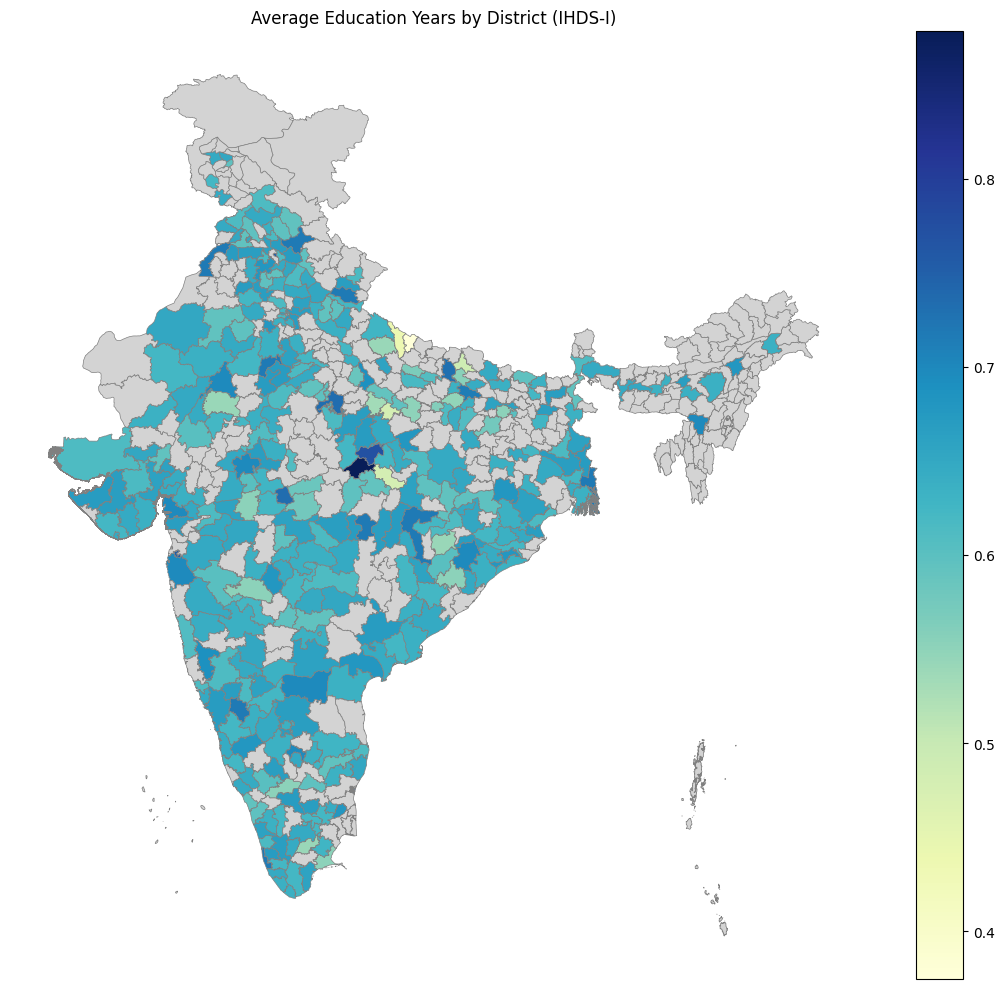

['baramula' 'srinagar' 'pulwama' 'rajauri' 'jammu' 'chamba' 'kangra'
 'kullu' 'mandi' 'hamirpur']
stateid                 int64
distid                  int64
district_name_clean    object
distname               object
state_name             object
merge_key              object
distname_matched       object
dtype: object


In [51]:
# Final key for merge
dist_lookup['merge_key'] = dist_lookup['distname_matched'] + '|' + dist_lookup['state_name']
districts['merge_key'] = districts['DISTRICT_clean'] + '|' + districts['ST_NM_clean']

# Merge in distid
districts_merged = districts.merge(dist_lookup[['distid', 'merge_key']], on='merge_key', how='left')

# Merge the feature values
ihds_agg = features.groupby('distid').agg({
    'education_years': 'mean',
    'household_income': 'mean'
}).reset_index()

districts_final = districts_merged.merge(ihds_agg, on='distid', how='left')

fig, ax = plt.subplots(figsize=(12, 10))
districts_final.plot(column='education_years',
                     cmap='YlGnBu',
                     linewidth=0.5,
                     edgecolor='grey',
                     legend=True,
                     missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
                     ax=ax)
plt.title('Average Education Years by District (IHDS-I)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(dist_lookup['distname'].unique()[:10])
print(dist_lookup.dtypes)

295
355
Keys in IHDS: 349
Keys in shapefile: 641
Unmatched example keys (from IHDS):
   wardha|chhattisgarh
   vellore|andhra pradesh
   nan
   solapur|odisha
           DISTRICT             ST_NM  distid
497      Saharanpur     Uttar Pradesh     1.0
622   West Godavari    Andhra Pradesh    15.0
33           Badgam   Jammu & Kashmir     NaN
337   Lahul & Spiti  Himachal Pradesh     NaN
289       Karimganj             Assam     NaN
30       Aurangabad             Bihar     NaN
586  Tiruvannamalai        Tamil Nadu     6.0
179            Etah     Uttar Pradesh     NaN
54         Baramula   Jammu & Kashmir     2.0
325            Kota         Rajasthan    30.0


 ['baramula' 'srinagar' 'pulwama' 'rajauri' 'jammu' 'chamba' 'kangra'
 'kullu' 'mandi' 'hamirpur']
stateid                 int64
distid                  int64
district_name_clean    object
distname               object
state_name             object
merge_key              object
distname_matched       object
dtype: object


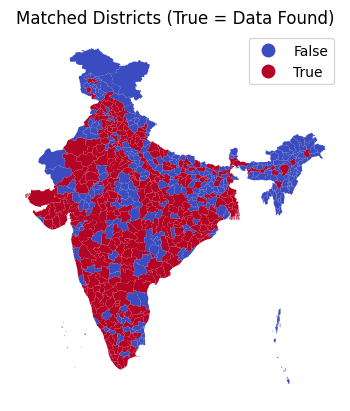

In [47]:
print(districts_merged['distid'].isna().sum())
print(districts_merged['distid'].notna().sum())

# Compare unique keys from both sides
print("Keys in IHDS:", dist_lookup['merge_key'].nunique())
print("Keys in shapefile:", districts['merge_key'].nunique())

# Find examples of unmatched keys
merged_keys = set(dist_lookup['merge_key'])
shapefile_keys = set(districts['merge_key'])
missing_keys = merged_keys - shapefile_keys

print("Unmatched example keys (from IHDS):")
for key in list(missing_keys)[:10]:
    print("  ", key)

print(districts_merged[['DISTRICT', 'ST_NM', 'distid']].sample(10))

districts_final['matched'] = districts_final['education_years'].notna()

print("\n\n", dist_lookup['distname'].unique()[:10])
print(dist_lookup.dtypes)

districts_final.plot(column='matched', cmap='coolwarm', legend=True)
plt.title("Matched Districts (True = Data Found)")
plt.axis('off')
plt.show()